In [30]:
# Adjoint SWE Solver (v28‑12)

%reload_ext autoreload 
# enables automatic reloading of modules before executing code
%autoreload 2 
# set to reload all modules (except those excluded by %aimport) every time before executing the Python code typed
import sys
print("System path:", sys.executable)
print("Python version:", sys.version)


# --- Python core packages ---
import numpy as np
import matplotlib.pyplot as plt

# --- FEniCS core ---
import dolfin as dlf
from dolfin import (
    Constant, Function, FunctionSpace, VectorFunctionSpace, 
    TestFunctions, TrialFunctions, Expression, interpolate, assign
)

# --- UFL symbolic tools ---
import ufl
from ufl import dot, div, grad, nabla_grad, sqrt, inner, derivative, Measure

# --- PETSc bindings for parallel linear algebra ---
from petsc4py import PETSc

# --- project-specific mesh/BC setup ---
from Adjoint_optimisation.set_up_mesh import *       # defines `mesh`
from Adjoint_optimisation.set_up_bcs import *        # defines `bcs`
from Adjoint_optimisation.place_turbines_random import *   #defintes "initial placement"

print("✅ Thesis adjoint SWE solver ready (v28-12)")

System path: /home/zabreedveld/miniconda3/envs/fenicsproject/bin/python
Python version: 3.10.19 | packaged by conda-forge | (main, Oct 22 2025, 22:29:10) [GCC 14.3.0]
✅ Thesis adjoint SWE solver ready (v28-12)


Parameters:

In [31]:
# Step 2 — Base physical & numerical parameters
# Define constants and parameters for the SWE model
# --- Physical constants ---
rho  = Constant(1025.0)     # density [kg/m³]
g    = Constant(9.81)       # gravity [m/s²]
nu   = Constant(1.0)        # eddy viscosity [m²/s]
h0   = Constant(40.0)       # mean depth [m]
# --- Turbine and drag coefficients ---
C_T = 0.7                   # thrust coefficient
C_D = 0.0025                # background drag coefficient
D = 5.0                     # turbine diameter [m]
sigma = 0.5*D               # gaussian width [m]
A_T = np.pi * D**2          # turbine swept area [m²]

# --- Flow and boundary data ---
U_inflow = 2.0              # deth-averaged inflow velocity [m/s]
initial_condition_u = Constant((0.0, 0.0))  # initial velocity field
initial_condition_eta = Constant(0.0)       # initial free surface elevation

# --- Domain size and mesh resolution ---
Lx, Ly = 500.0, 400.0    # domain dimensions [m]
Nx, Ny = 50, 40          # mesh resolution

# --- Turbine layout parameters ---
n_turbines = 15 # number of turbines
min_spacing = 5 * D # minimum spacing between turbines [m]

# --- Plot toggles ---
show_mesh_plot = True # toggle to plot the mesh

print(f"✅ Base parameters initialized successfully, Zoë.")


✅ Base parameters initialized successfully, Zoë.


Building mesh, inserting boundary conditions and initial placement of turbines

W type: <class 'dolfin.function.functionspace.FunctionSpace'>
v type: <class 'ufl.tensors.ListTensor'>
q type: <class 'ufl.indexed.Indexed'>
❤️ Mesh and mixed space initialised correctly (FEniCS 2019)


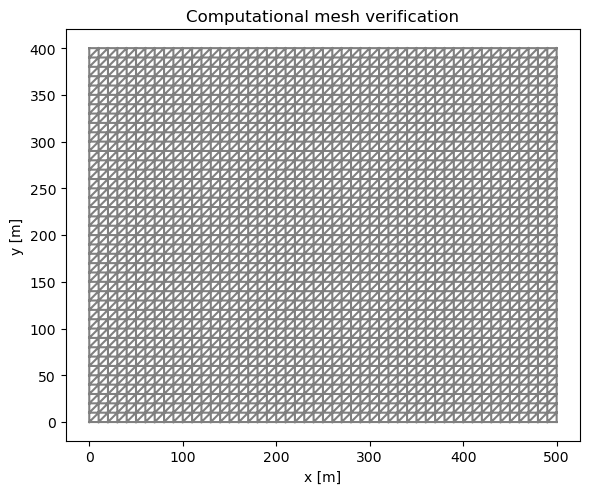

✅ Boundary markers created and BCs applied:
   - Inlet  (ID=1): inflow velocity = 2.00 m/s
   - Outlet (ID=2): open boundary (no Dirichlet condition)
   - Walls  (ID=3): free‑slip (no Dirichlet BC)

Managed to place  15  turbines within  17  attempts.


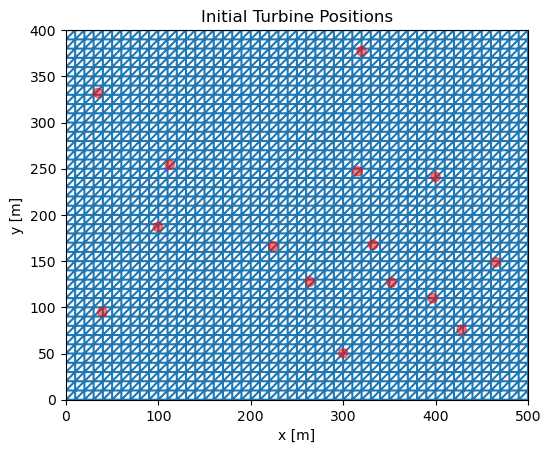

the initial turbine positions are: [[264.14833116 127.81343005]
 [319.95643449 377.26658662]
 [224.30549668 166.05425372]
 [428.27330781  75.76550924]
 [ 39.40891141  94.82518191]
 [300.08340727  50.33166798]
 [400.14855581 241.15993335]
 [ 34.66997964 332.02434396]
 [112.30111453 254.22617304]
 [315.82723602 247.17525205]
 [396.97021333 109.81478815]
 [332.48709155 167.68636876]
 [ 99.53471884 186.98840187]
 [465.33464911 148.76735984]
 [352.42220659 126.8737532 ]]


In [34]:
mesh, W, w, u, eta, v, q = mesh_set_up(Lx, Ly, Nx, Ny, show_mesh_plot)
boundary_markers, bcs = setup_boundary_markers_and_bcs(mesh, W, Lx, Ly, U_inflow)
initial_positions = place_turbines_random2(mesh, Lx, Ly, n_turbines, min_spacing, D, mesh)
print("the initial turbine positions are:", initial_positions)

In [ ]:
from dolfin_adjoint import *

J_F = derivative(F, w)
problem = NonlinearVariationalProblem(F, w, bcs, J=J_F)
solver = NonlinearVariationalSolver(problem)
solver.solve()

AttributeError: 'Argument' object has no attribute 'function_space'

In [12]:
# Control space and control variable
#V_ctrl = FunctionSpace(mesh, "CG", 1)

mesh_dolfin = mesh
true_mesh = getattr(mesh_dolfin, "_ad_fwd", mesh_dolfin)
V_ctrl = FunctionSpace(true_mesh, "CG", 1)
print(hasattr(V_ctrl, "_cpp_object"))   # now True

print(type(V_ctrl))
print(hasattr(V_ctrl, "_cpp_object"))


mesh_dolfin = mesh 

print(type(V_ctrl))
print(hasattr(V_ctrl, "_cpp_object"))


cb = Function(V_ctrl, name="cb")
cb.assign(Constant(0.0025))

# State equation setup
H = h0 + eta
f_body = Constant((0.0, 0.0))

V_sub = W.sub(0).collapse()
u_guess = interpolate(Constant((U_inflow*0.8, 0.0)), V_sub)
dlf.assign(w.sub(0), u_guess)

#dx = ufl.Measure("dx", domain=mesh)
dx = ufl.Measure("dx", domain=mesh_dolfin)

 
F = (
    dlf.inner(nu * dlf.grad(u), dlf.grad(v)) * dx                    # Diffusion
    + dlf.inner(dlf.dot(u, dlf.nabla_grad(u)), v) * dx               # Advection
    - g * dlf.div(H * v) * eta * dx                                  # Pressure gradient
    + (cb / H) * dlf.inner(u * dlf.sqrt(dlf.dot(u, u)), v) * dx      # Bottom friction
    + H * dlf.div(u) * q * dx                                        # Continuity
    - dlf.inner(f_body, v) * dx                                      # Forcing
)
#F += (Ct_field / H) * inner(u * sqrt(dot(u, u)), v) * dx

for f in F.arguments():
    print(f, type(f))


print(type(cb), type(eta), type(H))

# Turbine momentum sink using spatially varying field
    #F += (Ct_field / H) * inner(u_ * sqrt(dot(u, u)), v) * dx

# -------------------
# Recorded forward solve
# -------------------
# --- Recorded forward solve (safe variant) ---
from ufl import derivative

# 1️⃣ make sure we linearise F w.r.t. the *same* Function object
J_F = derivative(F, w)   # explicit du=None keeps it clean

# 2️⃣ unwrap w if it's an adjoint proxy
w_fwd = getattr(w, "_ad_fwd", w)

# 3️⃣ build and solve
print("type(F):", type(F))
print("F.arguments():", F.arguments())

print("type(w):", type(w))
print("id_of_w_in_F:", [a.number() for a in F.arguments()])
print("J_F_arguments:", J_F.arguments())


from dolfin_adjoint import stop_annotating

with stop_annotating():
    problem = dlf.NonlinearVariationalProblem(F, w, bcs, J=J_F)


#problem = dlf.NonlinearVariationalProblem(F, w_fwd, bcs, J=J_F)
    solver  = dlf.NonlinearVariationalSolver(problem)

solver.parameters["newton_solver"]["linear_solver"] = "mumps"
solver.parameters["newton_solver"]["absolute_tolerance"] = 1e-8
solver.parameters["newton_solver"]["relative_tolerance"] = 1e-7

solver.solve()
print("✅ Forward SWE solve complete.")

print("✅ Forward SWE solve complete.")

from dolfin_adjoint.tape import get_working_tape
print("Tape blocks:", len(get_working_tape()._blocks))


# -------------------
# Objective Functional (assemble *after* solve)
# -------------------
J_form = 0.5 * inner(u, u)*dx        # e.g. measure kinetic energy
J = adj.assemble(J_form)                 # scalar value recorded on tape

# -------------------
# Adjoint / gradient
# -------------------
m = adj.Control(cb)
rf = adj.ReducedFunctional(J, m)
grad = rf.derivative()

print("Adjoint gradient computed.")


True
<class 'dolfin.function.functionspace.FunctionSpace'>
True
<class 'dolfin.function.functionspace.FunctionSpace'>
True
v_0 <class 'dolfin.function.argument.Argument'>
<class 'dolfin.function.function.Function'> <class 'ufl.indexed.Indexed'> <class 'ufl.algebra.Sum'>
type(F): <class 'ufl.form.Form'>
F.arguments(): (Argument(FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 25), MixedElement(VectorElement(FiniteElement('Lagrange', triangle, 2), dim=2), FiniteElement('Lagrange', triangle, 1))), 0, None),)
type(w): <class 'dolfin.function.function.Function'>
id_of_w_in_F: [0]
J_F_arguments: (Argument(FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 25), MixedElement(VectorElement(FiniteElement('Lagrange', triangle, 2), dim=2), FiniteElement('Lagrange', triangle, 1))), 0, None), Argument(FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 25), MixedElement(VectorElement(FiniteElement('Lagrange', 

AttributeError: 'Argument' object has no attribute 'function_space'

In [13]:
print("F type:", type(F))
print("unknown type:", type(w))

print(type(w))
print(type(v))
print(type(F))

print(type(V_ctrl))
print(type(cb))

print("cb type:", type(cb))
print("F type:", type(F))
print("grad type:", type(grad))

print("mesh type:", type(mesh))
print(mesh)

print("w:", type(w))
print("u:", type(u))
print("eta:", type(eta))
print("v:", type(v))

(v, q) = TestFunctions(W)
print("v:", type(v))


F type: <class 'ufl.form.Form'>
unknown type: <class 'dolfin.function.function.Function'>
<class 'dolfin.function.function.Function'>
<class 'ufl.tensors.ListTensor'>
<class 'ufl.form.Form'>
<class 'dolfin.function.functionspace.FunctionSpace'>
<class 'dolfin.function.function.Function'>
cb type: <class 'dolfin.function.function.Function'>
F type: <class 'ufl.form.Form'>
grad type: <class 'function'>
mesh type: <class 'dolfin.cpp.generation.RectangleMesh'>
w: <class 'dolfin.function.function.Function'>
u: <class 'ufl.tensors.ListTensor'>
eta: <class 'ufl.indexed.Indexed'>
v: <class 'ufl.tensors.ListTensor'>
v: <class 'ufl.tensors.ListTensor'>
